In [259]:
import numpy as np
#from itertools import permutations
# imports for 3d scatterplot to show config
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# monomer class
class BFMMonomer:
    def __init__(self, Pos = np.zeros(3), Neighbors = [], IsFixed = False):
        self.pos = Pos
        self.neighbors = Neighbors
        self.isFixed = IsFixed

# system class
class BFMSimulator:
    # initialise: set up an empty simulation box and the lookup tables for bondset and moves
    def __init__(self, BoxX = 32, BoxY = 32, BoxZ = 32, PeriodicX = True, PeriodicY = True, PeriodicZ = True):
        self.boxX = BoxX
        self.boxY = BoxY
        self.boxZ = BoxZ
        self.periodicX = PeriodicX
        self.periodicY = PeriodicY
        self.periodicZ = PeriodicZ
        self.lattice = np.zeros((self.boxX,self.boxY,self.boxZ), dtype=np.int8)
        self.molecules = []
        self.numMonos = len(self.molecules)
        self.moveDirections = {0 : np.array([1, 0, 0]),
                          1 : np.array([-1, 0, 0]),
                          2 : np.array([0, 1, 0]),
                          3 : np.array([0, -1, 0]),
                          4 : np.array([0, 0, 1]),
                          5 : np.array([0, 0, -1])
                         }
        self.bondset = self.setupBondset()
        
    # perform one full monte carlo step
    def performMcs(self):
        # loop over the numer of monomers
        for i in range(self.numMonos):
            
            # get a random index
            idx = np.random.randint(0,self.numMonos)
            
            checker = True
            # check fix
            if(self.checkFix(idx)):
                checker = False
            
            #get a random move direction
            moveIdx = np.random.randint(0,6)
            
            # check boundaries
            if(self.checkBoundaries(idx,moveIdx)):
                checker = False
            
            # check bonds
            if(self.checkBonds(idx,moveIdx)):
                checker = False
            
            # check excluded volume
            if(self.checkExcludeVolume(idx,moveIdx)):
                checker = False
            
            # still True? perform the move
            if(checker):
                self.moveOnLattice(idx,moveIdx)
                #print("moved monomer idx ",idx)
            #print(i, idx, self.moveDirections[moveIdx])
    
    ########################################################################
    # system setup functions
    
    # add a linear chain simply in x direction
    def addLinearChain(self,n, pos0=np.zeros(3), fix = set([])):
        # dont use n=2 ;o)
        if (n==1):
            self.addMonomer(pos0)
        elif n ==2:
            firstNewIdx = self.numMonos
            self.addMonomer(pos0,[firstNewIdx+1])
            self.addMonomer(pos0 + np.array((2,0,0)),[firstNewIdx])
        elif n > 2:
            firstNewIdx = self.numMonos
            self.addMonomer(pos0,[firstNewIdx+1])
            for i in range(n-2):
                myIdx = firstNewIdx+1+i
                self.addMonomer(pos0+(i+1)*np.array((2,0,0)), [myIdx-1,myIdx+1])
            self.addMonomer(pos0+(n-1)*np.array((2,0,0)),[firstNewIdx+(n-2)])
        # set new size
        self.numMonos = len(self.molecules)
            
    ########################################################################
    # checker functions -> negation check = return true if conflict arise:
    
    # check "feature" fixed monomers
    def checkFix(self, idx):
        return self.molecules[idx].isFixed
    
    # check "feature" box
    def checkBoundaries(self,idx, moveIdx):
        # check boundaries, return True if conflict arised
        moveDir = self.moveDirections[moveIdx]
        # x-direction
        if (moveIdx == 0 or moveIdx == 1) and self.periodicX == False:
            if (self.molecules[idx].pos[0] + moveDir[0] == self.boxX):
                return True
            if (self.molecules[idx].pos[0] + moveDir[0] == 0):
                return True
        # y-direction
        if (moveIdx == 2 or moveIdx == 3) and self.periodicY == False:
            if (self.molecules[idx].pos[1] + moveDir[1] == self.boxY):
                return True
            if (self.molecules[idx].pos[1] + moveDir[1] == 0):
                return True
        # z-direction
        if (moveIdx == 4 or moveIdx == 5) and self.periodicZ == False:
            if (self.molecules[idx].pos[2] + moveDir[2] == self.boxZ):
                return True
            if (self.molecules[idx].pos[2] + moveDir[2] == 0):
                return True
        # no return until here? no conflicts
        return False
    
    # check "feature" Bondset
    def checkBonds(self,idx, moveIdx):
        # check all neighbors
        moveDir = self.moveDirections[moveIdx]
        # loop over beighbors, set checker to true if conflict arised
        for n in self.molecules[idx].neighbors:
            bond = self.molecules[n].pos-(self.molecules[idx].pos + moveDir)
            if not (tuple(bond) in self.bondset):
                # if bond not in bondset return True
                return True
        return False
    
    # check "feature" excluded volume
    def checkExcludeVolume(self, idx, moveIdx):
        
        return False
    
    ########################################################################
    # helper functions:
    
    # setup the bfm bondset in 3D
    def setupBondset(self):
    #    bonds = [[2,0,0],[2,1,0],[2,1,1],[2,2,1],[3,0,0],[3,1,0]]
    #    dummy = []
    #    for b in bonds:
    #        b = np.asarray(b)
    #        set1 = list( itertools.permutations(b) )
    #        set2 = list( itertools.permutations(-1*b) )
    #        setall = [tuple(i) for i in (set1 + set2)]
    #        dummy += setall
    #    return frozenset(dummy)
    # if itertools not available:
         return frozenset({(-3, -1, 0),(-3, 0, -1),(-3, 0, 0),(-2, -2, -1),(-2, -1, -2),(-2, -1, -1),(-2, -1, 0),(-2, 0, -1),(-2, 0, 0),(-1, -3, 0),(-1, -2, -2),(-1, -2, -1),(-1, -2, 0),(-1, -1, -2),(-1, 0, -3),(-1, 0, -2),(0, -3, -1),(0, -3, 0),(0, -2, -1),(0, -2, 0),(0, -1, -3),(0, -1, -2),(0, 0, -3),(0, 0, -2),(0, 0, 2),(0, 0, 3),(0, 1, 2),(0, 1, 3),(0, 2, 0),(0, 2, 1),(0, 3, 0),(0, 3, 1),(1, 0, 2),(1, 0, 3),(1, 1, 2),(1, 2, 0),(1, 2, 1),(1, 2, 2),(1, 3, 0),(2, 0, 0),(2, 0, 1),(2, 1, 0),(2, 1, 1),(2, 1, 2),(2, 2, 1),(3, 0, 0),(3, 0, 1),(3, 1, 0)})
    
    # write 0 (free) or 1 (occupied) to lattice
    def setToLattice(self,pos, value = 1):
        x = int(pos[0]%(self.boxX-1))
        y = int(pos[1]%(self.boxY-1))
        z = int(pos[2]%(self.boxZ-1))
        self.lattice[x,y,z] = value
        self.lattice[x+1,y,z] = value
        self.lattice[x,y+1,z] = value
        self.lattice[x,y,z+1] = value
        self.lattice[x+1,y+1,z] = value
        self.lattice[x+1,y,z+1] = value
        self.lattice[x,y+1,z+1] = value
        self.lattice[x+1,y+1,z+1] = value
        
        
    def moveOnLattice(self,idx,moveIdx):
        moveDir = self.moveDirections[moveIdx]
        # free old positon
        self.setToLattice(self.molecules[idx].pos,0)
        # occupy new positon
        self.setToLattice(self.molecules[idx].pos+moveDir, 1)
        # move the monomer
        self.molecules[idx].pos = self.molecules[idx].pos + moveDir
            
        
    def addMonomer(self, pos, neigbors = []):
        self.molecules.append( BFMMonomer(pos,neigbors) )
        self.setToLattice(pos)
        
    ########################################################################
    # visualisation functions:
    def plotConfig(self):
        x=[ mono.pos[0]%(self.boxX-1) for mono in self.molecules ]
        y=[ mono.pos[1]%(self.boxY-1) for mono in self.molecules ]
        z=[ mono.pos[2]%(self.boxZ-1) for mono in self.molecules ]

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x,y,z)
        ax.set_xlim(0,self.boxX)
        ax.set_ylim(0,self.boxY)
        ax.set_zlim(0,self.boxZ)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        plt.savefig("configScatterplot.png")
        

In [260]:
hugo = BFMSimulator()

In [261]:
hugo.addLinearChain(16)

In [262]:
for i in range(hugo.numMonos):
    print(i, hugo.molecules[i].pos, hugo.molecules[i].neighbors)

0 [0. 0. 0.] [1]
1 [2. 0. 0.] [0, 2]
2 [4. 0. 0.] [1, 3]
3 [6. 0. 0.] [2, 4]
4 [8. 0. 0.] [3, 5]
5 [10.  0.  0.] [4, 6]
6 [12.  0.  0.] [5, 7]
7 [14.  0.  0.] [6, 8]
8 [16.  0.  0.] [7, 9]
9 [18.  0.  0.] [8, 10]
10 [20.  0.  0.] [9, 11]
11 [22.  0.  0.] [10, 12]
12 [24.  0.  0.] [11, 13]
13 [26.  0.  0.] [12, 14]
14 [28.  0.  0.] [13, 15]
15 [30.  0.  0.] [14]


In [245]:
hugo.performMcs()

In [218]:
hugo.lattice

array([[[1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [20]:
bonds = [[2,0,0],[2,1,0],[2,1,1],[2,2,1],[3,0,0],[3,1,0]]

In [271]:
bonds = [[2,0,0],[2,1,0],[2,1,1],[2,2,1],[3,0,0],[3,1,0]]
dummy = []
for b in bonds:
    b = np.asarray(b)
    set1 = list( itertools.permutations(b) )
    set2 = list( itertools.permutations(-1*b) )
    setall = [tuple(i) for i in (set1 + set2)]
    dummy += setall
a=frozenset(dummy)
a

frozenset({(-3, -1, 0),
           (-3, 0, -1),
           (-3, 0, 0),
           (-2, -2, -1),
           (-2, -1, -2),
           (-2, -1, -1),
           (-2, -1, 0),
           (-2, 0, -1),
           (-2, 0, 0),
           (-1, -3, 0),
           (-1, -2, -2),
           (-1, -2, -1),
           (-1, -2, 0),
           (-1, -1, -2),
           (-1, 0, -3),
           (-1, 0, -2),
           (0, -3, -1),
           (0, -3, 0),
           (0, -2, -1),
           (0, -2, 0),
           (0, -1, -3),
           (0, -1, -2),
           (0, 0, -3),
           (0, 0, -2),
           (0, 0, 2),
           (0, 0, 3),
           (0, 1, 2),
           (0, 1, 3),
           (0, 2, 0),
           (0, 2, 1),
           (0, 3, 0),
           (0, 3, 1),
           (1, 0, 2),
           (1, 0, 3),
           (1, 1, 2),
           (1, 2, 0),
           (1, 2, 1),
           (1, 2, 2),
           (1, 3, 0),
           (2, 0, 0),
           (2, 0, 1),
           (2, 1, 0),
           (2, 1, 1),
      

In [220]:
(3,1,0) in a

True

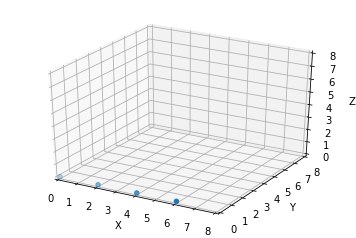

In [246]:
hugo.plotConfig()

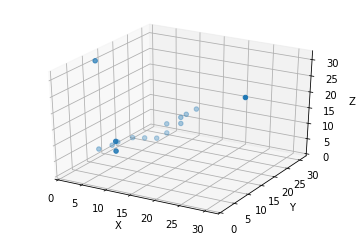

In [270]:
for _ in range(10000):
    hugo.performMcs()
hugo.plotConfig()